# Chess Position to FEN

In [ ]:
from pathlib import Path
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [18]:
train_dir = Path("dataset/train")
test_dir = Path("dataset/test")

train_sample_count = 8000
test_sample_count = 2000

# find all JPEGs and convert to a list
all_train_paths_list = list(train_dir.glob("*.jpeg"))
all_test_paths_list = list(test_dir.glob("*.jpeg"))

train_data_paths = random.sample(all_train_paths_list, train_sample_count)
test_data_paths = random.sample(all_test_paths_list, test_sample_count)

# select a random img for displaying
rand_training = random.randint(0, train_sample_count)

In [20]:
def get_fen_from_path(image_path: Path):

    # .stem to get the filename without the extension.
    filename_stem = image_path.stem
    
    fen_notation = filename_stem.replace('-', '/')
    return fen_notation

Example path: dataset\train\R5R1-8-p5R1-2K1k3-1nB3b1-n7-5n2-4r3.jpeg
Extracted FEN: R5R1/8/p5R1/2K1k3/1nB3b1/n7/5n2/4r3


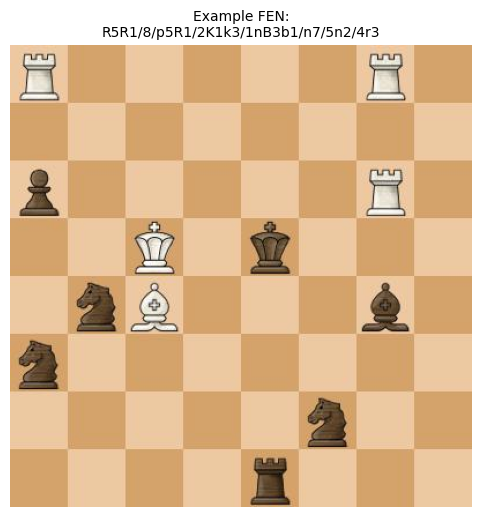

In [21]:
example_path = train_data_paths[rand_training]
example_fen = get_fen_from_path(example_path)
example_image = cv2.imread(str(example_path))
example_image_rgb = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(example_image_rgb)
plt.title(f"Example FEN:\n{example_fen}", fontsize=10)
plt.axis('off')
plt.savefig("example_fen_image.png")

print(f"Example path: {example_path}")
print(f"Extracted FEN: {example_fen}")

### Transforming FEN notation to be used for preprocessing

In [ ]:
# Define the piece-to-integer mapping
# 0 is reserved for empty squares.
PIECE_TO_INT = {
    'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
    'p': 7, 'n': 8, 'b': 9, 'r': 10, 'q': 11, 'k': 12
}

def parse_fen_to_labels(fen_string: str) -> np.ndarray:
    # list to hold the 64 labels in a flat 1D structure
    flat_labels = []
    
    # split the FEN string into its 8 ranks
    ranks = fen_string.split('/')
    
    for rank in ranks:
        for char in rank:
            if char.isdigit():
                # If it's a number, add that many empty squares (label 0)
                flat_labels.extend([0] * int(char))
            elif char in PIECE_TO_INT:
                # If it's a piece, add its corresponding integer label
                flat_labels.append(PIECE_TO_INT[char])

    # Convert the flat list of 64 labels into an 8x8 matrix
    board_matrix = np.array(flat_labels, dtype=np.uint8).reshape((8, 8))
    
    return board_matrix

In [24]:
def process_and_extract_squares(image_path: Path, 
                                board_size: int = 400, 
                                square_size: int = 50):    
    
    image = cv2.imread(str(image_path))
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_board = cv2.resize(gray_image, (board_size, board_size), 
                             interpolation=cv2.INTER_AREA)
    
    squares = []
    for y in range(0, board_size, square_size):
        for x in range(0, board_size, square_size):
            square = resized_board[y:y+square_size, x:x+square_size]
            squares.append(square)
    return resized_board, squares

Saved 'preprocessed_board.png' and 'cropped_example_E4.png'
Total squares extracted: 64


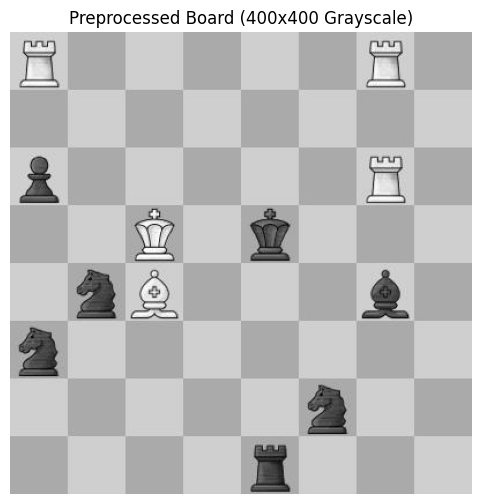

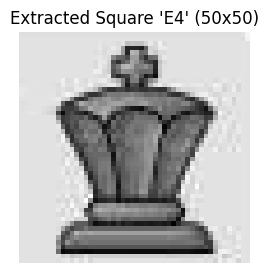

In [34]:
# Define the target sizes
BOARD_DIM = 400
SQUARE_DIM = 50

processed_board, all_squares = process_and_extract_squares(example_path, BOARD_DIM, SQUARE_DIM)

plt.figure(figsize=(6, 6))
plt.imshow(processed_board, cmap='gray')
plt.title(f"Preprocessed Board ({BOARD_DIM}x{BOARD_DIM} Grayscale)")
plt.axis('off')
plt.savefig("preprocessed_board.png")

# loop creates squares from top-left (A8) to bottom-right (H1).
# The index for 'E4' is 36.
e4_square = all_squares[28]

plt.figure(figsize=(3, 3))
plt.imshow(e4_square, cmap='gray')
plt.title(f"Extracted Square 'E4' ({SQUARE_DIM}x{SQUARE_DIM})")
plt.axis('off')
plt.savefig("cropped_example_E4.png")

print("Saved 'preprocessed_board.png' and 'cropped_example_E4.png'")
print(f"Total squares extracted: {len(all_squares)}")

## Import necessary libraries for model development

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D,Dropout, Dense, Flatten, MaxPooling2D, Reshape, Input, TimeDistributed, BatchNormalization, Conv3D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

### Preparing dataset with just squares

In [59]:
BOARD_DIM = 400
SQUARE_DIM = 50 # BOARD_DIM / 8
NUM_CLASSES = 13

def build_and_prepare_dataset(file_paths, num_classes=NUM_CLASSES):
    all_squares = []
    all_labels = []
    
    print(f"Processing {len(file_paths)} board images...")
    for path in file_paths:
        _, squares_list = process_and_extract_squares(path, BOARD_DIM, SQUARE_DIM)
        if squares_list is None: # In case an image fails to load
            continue
            
        fen_str = get_fen_from_path(path)
        label_matrix = parse_fen_to_labels(fen_str) # This is an 8x8 matrix
        
        # Flatten the 8x8 matrix into a 1D list of 64 labels
        # [label_A8, label_B8, ..., label_H1]
        labels_list = label_matrix.flatten()
        
        # Add these 64 squares and 64 labels to the master lists
        all_squares.extend(squares_list)
        all_labels.extend(labels_list)
        
    print("Converting to NumPy arrays...")
    # Create the final X (data) and y (labels) arrays
    X = np.array(all_squares)
    y = np.array(all_labels)
    
    # Final Pre-processing for the CNN
    
    # Normalization
    X = X.astype('float32') / 255.0
    
    # Current shape: (N, 50, 50) -> New shape: (N, 50, 50, 1) as CNNs expect a channel anyway
    X = np.expand_dims(X, -1)
    
    # One-hot encode the labels
    y = to_categorical(y, num_classes)
    
    return X, y

In [60]:
# Build the training set
X_train, y_train = build_and_prepare_dataset(train_data_paths, NUM_CLASSES)

# Build the testing set
X_test, y_test = build_and_prepare_dataset(test_data_paths, NUM_CLASSES)

print("\n--- Final Dataset Shapes ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
# 8000 x 64 = 512000
# 2000 x 64 = 128000

Processing 8000 board images...
[0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 9, 3, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 10, 0, 0, 12, 0, 0, 1, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 8, 0, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 12, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

### Model Architecture

In [ ]:
input_shape = (50, 50, 1) # 50x50 greyscale images
num_classes = 13


model = Sequential()

model.add(Input(shape=input_shape))

# 32 filters, 3x3 kernel
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

model.add(MaxPooling2D((2, 2))) # Downscales the image

# 64 filters
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten()) # Flattens the 2D image data into a 1D vector

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))
    
# final output layer
model.add(Dense(num_classes, activation='softmax'))

### Compile the model

In [ ]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,200,269 (4.58 MB)

 Trainable params: 1,200,269 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("--- Starting Model Training ---")

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_test, y_test) 
)

print("--- Training Complete ---")

--- Starting Model Training (This will take a while!) ---
Epoch 1/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 542s 134ms/step - accuracy: 0.9627 - loss: 0.1316 - val_accuracy: 1.0000 - val_loss: 2.1412e-04
Epoch 2/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 512s 128ms/step - accuracy: 0.9942 - loss: 0.0146 - val_accuracy: 1.0000 - val_loss: 7.7547e-06
Epoch 3/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 419s 105ms/step - accuracy: 0.9963 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 2.8702e-06
Epoch 4/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 420s 105ms/step - accuracy: 0.9978 - loss: 0.0058 - val_accuracy: 1.0000 - val_loss: 9.0613e-07
Epoch 5/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 414s 103ms/step - accuracy: 0.9986 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 1.5979e-06
Epoch 6/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 413s 103ms/step - accuracy: 0.9989 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 8.1715e-06
Epoch 7/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 430s 107ms/step - accuracy: 0.9990 - loss: 0.0027 - val_accuracy: 1.0000

### Evaluate the model on the test set

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Final Test Accuracy: {test_acc * 100:.2f}%')


--- Evaluating Model ---
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - accuracy: 1.0000 - loss: 3.1388e-08


Final Test Accuracy: 100.00%
Saving model as 'piece_classifier_model.h5'...
Model saved successfully!


### Save the model

In [52]:
model.save('piece_classifier_model.h5')
print("Model saved successfully!")

Model saved successfully!


## Testing with real input

In [50]:
# same mappings as in training
PIECE_TO_INT = {
    'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
    'p': 7, 'n': 8, 'b': 9, 'r': 10, 'q': 11, 'k': 12
}

# reverse mapping to convert numbers back to piece characters
INT_TO_PIECE = {v: k for k, v in PIECE_TO_INT.items()}
INT_TO_PIECE[0] = '1' # '1' is the FEN character for an empty square

def process_and_extract_squares(image_path: Path, board_size: int = 400, square_size: int = 50):
    image = cv2.imread(str(image_path))
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
        
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_board = cv2.resize(gray_image, (board_size, board_size), 
                             interpolation=cv2.INTER_AREA)
    
    squares = []
    for y in range(0, board_size, square_size):
        for x in range(0, board_size, square_size):
            square = resized_board[y:y+square_size, x:x+square_size]
            squares.append(square)
            
    return resized_board, squares

def labels_to_fen(labels_array):
    fen_string = ""
    empty_count = 0
    
    for i, label_int in enumerate(labels_array):
        
        # At the end of every rank
        if i > 0 and i % 8 == 0:
            if empty_count > 0:
                fen_string += str(empty_count) # Add the count of empty squares
            fen_string += '/'
            empty_count = 0
        
        piece_char = INT_TO_PIECE[label_int]
        
        if piece_char == '1':
            empty_count += 1
        else:
            if empty_count > 0:
                fen_string += str(empty_count) # Add pending empty squares
                empty_count = 0
            fen_string += piece_char
            
    # Add any remaining empty square count for the last rank
    if empty_count > 0:
        fen_string += str(empty_count)
        
    return fen_string

def predict_fen_from_image(image_path_str, model_path):
    model = load_model(model_path)
    print("Model loaded.")
    
    image_path = Path(image_path_str)
    _, all_squares = process_and_extract_squares(image_path)

    X_pred = np.array(all_squares)
    X_pred = X_pred.astype('float32') / 255.0
    X_pred = np.expand_dims(X_pred, -1) # Shape becomes (64, 50, 50, 1)
    
    predictions = model.predict(X_pred)
    
    # find the most likely class for each square
    predicted_labels = np.argmax(predictions, axis=1)

    fen = labels_to_fen(predicted_labels)
    
    return fen

In [51]:
MODEL_FILE = 'piece_classifier_model.h5'
TEST_IMAGE = 'test-img.png'

try:
    predicted_fen = predict_fen_from_image(TEST_IMAGE, MODEL_FILE)
    print(f"Image: {TEST_IMAGE}")
    print(f"Predicted FEN: {predicted_fen}")

except FileNotFoundError as e:
    print(f"\nERROR: Could not find a file. {e}")
except Exception as e:
    print(f"An error occurred: {e}")

Model loaded.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image: test-img.png
Predicted FEN: r6k/1p1P2pp/4P3/8/p5P1/P1Br3P/1P2q3/K3R2R
